In [1]:
from platform import python_version

print(python_version())

3.8.5


In [21]:
import pandas as pd
import numpy as np

import os
os.chdir('..')
import nltk
from utils import functions
import spacy

from nltk.parse.corenlp import CoreNLPParser, CoreNLPDependencyParser
from gensim.models import KeyedVectors
from tqdm import tqdm

from nltk.corpus import wordnet as wn

In [3]:
data_path = './DATA_SETS'

mens_path = 'MEN'
sick_path = 'SICK'
sts_path = 'STS'

parsers = {'seq': CoreNLPParser(url='http://localhost:9000'),
           'syn': CoreNLPParser(url='http://localhost:9000'),
           'dep': CoreNLPDependencyParser(url='http://localhost:9000')}

column_names = ['identifier', 'text']

In [19]:
def sort_text(text, criteria, parsers, start):
    sents = nltk.sent_tokenize(text)
    
    if len(sents) > 1:
        return [functions.sort_def(s, criteria=criteria, parser=parsers[criteria], start=start) for s in sents]
    else:
        return functions.sort_def(sents[0], criteria=criteria, parser=parsers[criteria], start=start)

def check_roots(tree, text):
    n_roots = 0
    for key, node in tree.nodes.items():
        if node['head'] is None:
            n_roots += 1
    if n_roots != 1:
        print('ERROR:N_ROOTS // ' + text)
            
def check_parents(tree, text):
    addresses = []
    for key, node in tree.nodes.items():
        if type(node['head']) is list and len(node['head'] > 1):
            print('ERROR:MULTIPLE_HEADS // ' + text + ' // ' + node['word'])
        if node['address'] in addresses:
            print('ERROR:MULTIPLE_HEADS // ' + text + ' // ' + node['word'])
        addresses.append(node['address'])
            
def check_free_nodes(tree, tokens):
    t_tokens = []
    skip_tokens = list('()"`.[]—{}') + ["''", '’’', '‘‘']
    for key, node in tree.nodes.items():
        t_tokens.append(node['word'])
        
    missing_tokens = tokens[~tokens.isin(t_tokens) & ~tokens.isin(skip_tokens)].tolist()
    
    if missing_tokens:
        print('ERROR:MULTIPLE_FREE_NODES // ' + str(tokens.tolist()) + ' // ' + str(missing_tokens))

def check_tree(text, criteria, parsers, start):
    sents = nltk.sent_tokenize(text)
    
    if len(sents) > 1:
        for s in sents:
            trees = list(parsers[criteria].raw_parse(s, keepPunct=True))
            
            # if len(trees) != 1:
            #     print('ERROR:N_TREES // ' + s)
                
            tree = trees[0]
            # check_roots(tree, s)
            check_parents(tree, s)
            # check_free_nodes(tree, pd.Series(parsers[criteria].tokenize(s)))
            
            # if tree.contains_cycle():
            #     print('ERROR:CONTAINS_CYCLE // ' + s)
    else:
        trees = list(parsers[criteria].raw_parse(sents[0], keepPunct=True))
            
        # if len(trees) != 1:
        #     print('ERROR:N_TREES // ' + text)

        tree = trees[0]
        # check_roots(tree, text)
        check_parents(tree, text)
        # check_free_nodes(tree, pd.Series(parsers[criteria].tokenize(text)))
        
        # if tree.contains_cycle():
        #     print('ERROR:CONTAINS_CYCLE // ' + text)

In [9]:
for path in [mens_path, sick_path, sts_path]:
    fname = [f for f in os.listdir(os.path.join(data_path, path)) if f.endswith('SENTENCES.txt')][0]
    print('Processing file ' + fname + '...')

    with open(os.path.join(data_path, path, fname), 'r', encoding='utf-8') as f:
        data = pd.read_csv(f, index_col=0, sep='\t', header=None, names=column_names)

    criteria = 'dep'
    data[['text']].apply(lambda x: check_tree(x['text'], criteria, parsers, 'right'), 
                         axis=1)

Processing file MEN_SENTENCES.txt...
Processing file SICK.SENTENCES.txt...
Processing file STS.TEST.SENTENCES.txt...


In [185]:
for path in [mens_path, sick_path, sts_path]:
    fname = [f for f in os.listdir(os.path.join(data_path, path)) if f.endswith('SENTENCES.txt')][0]
    print('Processing file ' + fname + '...')
    
    with open(os.path.join(data_path, path, fname), 'r', encoding='utf-8') as f:
        data = pd.read_csv(f, index_col=0, sep='\t', header=None, names=column_names)
    
    print('Number of sentences to sort: ' + str(data.shape[0]))
    for criteria in parsers:
        if criteria == 'dep':
            for start in ['left', 'right']:
                print('Sorting texts according to ' + criteria + ', starting at the ' + start + '...')
                data[criteria + '_' + start] = data[['text']].apply(lambda x: 
                                                                    sort_text(x['text'], criteria, parsers, start), 
                                                                    axis=1)
        else:
            print('Sorting texts according to ' + criteria + '...')
            start = 'right'
            data[criteria] = data[['text']].apply(lambda x: sort_text(x['text'], criteria, parsers, start), 
                                                  axis=1)

    print('Saving results to csv and pickle files...')
    data.to_csv(os.path.join(data_path, path, fname[:-4] + '2.csv'), sep='\t')
    data.to_pickle(os.path.join(data_path, path, fname[:-4] + '2.pkl'))
    print()

Processing file STS.TEST.SENTENCES.txt...
Number of sentences to sort: 2204
Sorting texts according to seq...
Sorting texts according to syn...
Sorting texts according to dep, starting at the left...
Adding missed tokens: ['Corp'] /// Electronic Data Systems Corp. Thursday said the Securities and Exchange Commission has asked the company for documents related to its large contract with the U.S. Navy.
Adding missed tokens: ['Va'] /// His sport utility vehicle was found June 25, abandoned without its license plates in Virginia Beach, Va.
Adding missed tokens: ['Corp'] /// Nvidia will take advantage of MediaQ customers, which include such players as Siemens AG, Sharp, Philips, Dell, Mitsubishi and Sony Corp.
Sorting texts according to dep, starting at the right...
Adding missed tokens: ['Corp'] /// Electronic Data Systems Corp. Thursday said the Securities and Exchange Commission has asked the company for documents related to its large contract with the U.S. Navy.
Adding missed tokens: ['

In [88]:
# Add the chunking to the saved file using spacy's chunker
def chunker(text, lang_model, bidirectionality=False):
    # tokens = nltk.word_tokenize(text)
    p_text = lang_model(text.replace('Near-Earth', 'NearEarth'))
    tokens = [token.text for token in p_text]
    chunks = [[t.text for t in lang_model(chunk.text.replace('NearEarth', 'Near Earth'))] 
              for chunk in p_text.noun_chunks]
    
    if chunks:
        t_id = 0
        c_text = []

        # Keep adding tokens in the original order
        for chunk in chunks:
            while tokens[t_id] != chunk[0]:
                c_text.append(tokens[t_id])
                t_id += 1
            if len(chunk) == 1:
                c_text.extend(chunk)
            else:
                c_text.append(chunk)
            t_id += len(chunk)

        # Add posterior tokens to last chunk
        last_ix = tokens.index(chunk[-1])
        c_text.extend(tokens[last_ix+1:])        
    
        if len(c_text) == 1 and type(c_text[0]) is list:
            c_text = c_text[0]
    
    else:
        c_text = tokens[:]
    
    # In-Chunks goes right-left and chunks goes left-right
    if bidirectionality:
        return c_text[::-1]
    else:
        return c_text

In [187]:
lang_model = spacy.load('en_core_web_sm')

for path in [sts_path]:  # mens_path, sick_path, 
    fname = [f for f in os.listdir(os.path.join(data_path, path)) if f.endswith('SENTENCES2.pkl')][0]
    print('Processing file ' + fname + '...')
    
    data = pd.read_pickle(os.path.join(data_path, path, fname))
    data['chunk'] = data[['text']].apply(lambda x: chunker(x['text'], lang_model, False), axis=1)
    
    print('Saving results to csv and pickle files...')
    data.to_csv(os.path.join(data_path, path, fname[:-4] + '.csv'), sep='\t')
    data.to_pickle(os.path.join(data_path, path, fname))
    print()

Processing file STS.TEST.SENTENCES2.pkl...
Saving results to csv and pickle files...



In [179]:
# Check which of the MEN words are not available in the MEN_SENTENCES2 dataset and 
# fill them in with the wordnet definitions
sentences = {}
experiments = {}
experiments_cols = ['text1', 'text2', 'gs']
dataset = 'MEN'
lang_model = spacy.load('en_core_web_sm')

files = os.listdir(os.path.join(data_path, dataset))
sentences_file = [f for f in files if f.endswith('SENTENCES2.pkl')][0]
experiments_file = [f for f in files if f.endswith('SIMILARITIES.txt')][0]

sentences[dataset] = pd.read_pickle(os.path.join(data_path, dataset, sentences_file))
experiments[dataset] = pd.read_csv(os.path.join(data_path, dataset, experiments_file), names=experiments_cols,
                                  header=None, index_col=0, sep='\t')

set1 = set(experiments[dataset].text1.tolist() + experiments[dataset].text2.tolist())
set2 = set(sentences[dataset].index.tolist())

for word in set1 - set2:
    print('WORD: ' + word)
    record = {'text': wn.synsets(word)[0].definition()}
    for criteria in parsers:
        if criteria == 'dep':
            for start in ['left', 'right']:
                record[criteria + '_' + start] = sort_text(record['text'], criteria, parsers, start)
        else:
            start = 'right'
            record[criteria] = sort_text(record['text'], criteria, parsers, start)
    
    record['chunk'] = chunker(record['text'], lang_model, False)
    sentences[dataset] = sentences[dataset].append(pd.Series(record, name=word))
    sentences[dataset].sort_index(inplace=True)
    
print('Saving results to csv and pickle files...')
sentences[dataset].to_csv(os.path.join(data_path, dataset, sentences_file[:-4] + '.csv'), sep='\t')
sentences[dataset].to_pickle(os.path.join(data_path, dataset, sentences_file))
print('...')

WORD: pencil
WORD: scratch
WORD: spider
WORD: firework
Adding missed tokens: ['etc'] /// (usually plural) a device with an explosive that burns at a low rate and with colored flames; can be used to illuminate areas or send signals etc.
Adding missed tokens: ['etc'] /// (usually plural) a device with an explosive that burns at a low rate and with colored flames; can be used to illuminate areas or send signals etc.
WORD: display
WORD: birthday
WORD: head
WORD: nail
WORD: gun
WORD: journal
WORD: break
WORD: tongue
WORD: graffito
WORD: copper
WORD: organ
WORD: vintage
WORD: pole
WORD: donut
WORD: ski
WORD: keyboard
WORD: panda
WORD: ipod
WORD: ink
WORD: beauty
WORD: snowman
WORD: figure
WORD: iris
WORD: badge
Adding missed tokens: ['etc'] /// an emblem (a small piece of plastic or cloth or metal) that signifies your status (rank or membership or affiliation etc.)
Adding missed tokens: ['etc'] /// an emblem (a small piece of plastic or cloth or metal) that signifies your status (rank or mem

---

## Word-Definition Dataset creation

---

In [4]:
# Let's first extract the words we want to appear in the dataset (Selected Option 2)
# Option 1: Take the wordsim and men datasets
# Option 2: Take a big corpus, lower the tokens, remove stopwords and select those that have a wordnet definition and
#           a Google vector.

In [59]:
import re

from nltk.corpus import brown
from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer

In [60]:
brown_toks = set(list(brown.words()))
len(brown_toks)

56057

In [64]:
brown_words = set([w.lower() for w in brown_toks if not re.findall('\d', w)])
print(len(brown_words))

47522


In [68]:
# Lemmatize the words to avoid having many repetitions of the same word skewing our results
lemmatizer = WordNetLemmatizer()

lemmas = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w, pos=wn.NOUN), 
                                                                         pos=wn.VERB), pos=wn.ADV), pos=wn.ADJ) 
          for w in brown_words]
lemmas = set(lemmas)
print(len(lemmas))

36072


In [27]:
# Read the stopwords file and the word2vec file
WV_FILE = 'GoogleNews-vectors-negative300.bin'
DATA_PATH2 = './data'

with open(os.path.join(DATA_PATH, 'stopwords_en.txt'), 'r', encoding='utf-8') as f:
    stopwords = [l.rstrip() for l in f.readlines()]

word2vecs = KeyedVectors.load_word2vec_format(os.path.join(DATA_PATH2, WV_FILE), binary=True)

In [69]:
# Keep only those lemmas that are not stopwords and do appear in both the wordnet defs and Google vectors
filt_lemmas = [w for w in lemmas if w in word2vecs.vocab.keys() and w not in stopwords and wn.synsets(w)]
len(filt_lemmas)

20184

In [70]:
filt_lemmas[:10]

['happenstance',
 'dialectically',
 'incredible',
 'greek',
 'credential',
 'traditionally',
 'intercollegiate',
 'exhibitor',
 'yarrow',
 'hesitate']

In [72]:
# Create dictionary with the words as indexes and the first definition in wordnet as the unique column
word_def = {w: wn.synsets(w)[0].definition() for w in filt_lemmas}

In [104]:
keys, values = zip(*word_def.items())
data = pd.DataFrame(values, index=keys, columns=['text'])
data.drop("rock'n'roll", inplace=True)

In [85]:
data.head()

,text
happenstance,an event that might have been arranged althoug...
dialectically,in a dialectic manner
incredible,beyond belief or understanding
greek,the Hellenic branch of the Indo-European famil...
credential,a document attesting to the truth of certain s...


In [87]:
fname = 'word_defs'
data_path = './DATA_SETS'
path = 'WORD_DEF'

# Sort the text according to nltk
for criteria in parsers:
    if criteria == 'dep':
        for start in ['left', 'right']:
            print('Sorting texts according to ' + criteria + ', starting at the ' + start + '...')
            data[criteria + '_' + start] = data[['text']].apply(lambda x: 
                                                                sort_text(x['text'], criteria, parsers, start), 
                                                                axis=1)
    else:
        print('Sorting texts according to ' + criteria + '...')
        start = 'right'
        data[criteria] = data[['text']].apply(lambda x: sort_text(x['text'], criteria, parsers, start), 
                                              axis=1)

print('Saving results to csv and pickle files...')
data.to_csv(os.path.join(data_path, path, fname + '.csv'), sep='\t')
data.to_pickle(os.path.join(data_path, path, fname + '.pkl'))
print()

Sorting texts according to seq...
Sorting texts according to syn...
Sorting texts according to dep, starting at the left...
Adding missed tokens: ['etc'] /// a precautionary measure warding off impending danger or damage or injury etc.
Adding missed tokens: ['etc'] /// the official symbols of a family, state, etc.
Adding missed tokens: ['etc'] /// any of several chemical elements that are usually shiny solids that conduct heat or electricity and can be formed into sheets etc.
Adding missed tokens: ['etc'] /// any physical damage to the body caused by violence or accident or fracture etc.
Adding missed tokens: ['etc'] /// a framework of steel bars raised on side supports to bridge over or around something; can display railway signals above several tracks or can support a traveling crane etc.
Adding missed tokens: ['etc'] /// a measuring instrument for measuring and indicating a quantity such as the thickness of wire or the amount of rain etc.
Adding missed tokens: ['etc'] /// any device

Adding missed tokens: ['etc'] /// one of a series of rounded projections (or the notches between them) formed by curves along an edge (as the edge of a leaf or piece of cloth or the margin of a shell or a shriveled red blood cell observed in a hypertonic solution etc.)
Adding missed tokens: ['etc'] /// a precautionary measure warding off impending danger or damage or injury etc.
Adding missed tokens: ['etc'] /// a medical dressing consisting of a soft heated mass of meal or clay that is spread on a cloth and applied to the skin to treat inflamed areas or improve circulation etc.
Adding missed tokens: ['etc'] /// a label written or printed on paper, cardboard, or plastic that is attached to something to indicate its owner, nature, price, etc.
Adding missed tokens: ['etc'] /// a way of regarding situations or topics etc.
Adding missed tokens: ['etc'] /// active support of an idea or cause etc.
Adding missed tokens: ['etc'] /// a disloyal person who betrays or deserts his cause or religio

Adding missed tokens: ['etc'] /// the act of intervening (as to mediate a dispute, etc.)
Adding missed tokens: ['etc'] /// a worker who bleaches (cloth or flour etc.)
Adding missed tokens: ['etc'] /// the act of getting recruits; enlisting people for the army (or for a job or a cause etc.)
Adding missed tokens: ['etc'] /// the act of being present (at a meeting or event etc.)
Adding missed tokens: ['etc'] /// make more attractive by adding ornament, colour, etc.
Adding missed tokens: ['etc'] /// make more attractive by adding ornament, colour, etc.
Adding missed tokens: ['etc'] /// the act of vindicating or defending against criticism or censure etc.
Adding missed tokens: ['etc'] /// the brush (small trees and bushes and ferns etc.)
Adding missed tokens: ['etc'] /// a list of items (names or tasks etc.)
Adding missed tokens: ['etc'] /// a hypothetical possibility, circumstance, statement, proposal, situation, etc.
Adding missed tokens: ['etc'] /// an ostentatious display (of effort or 

Adding missed tokens: ['etc'] /// a structure that allows people or vehicles to cross an obstacle such as a river or canal or railway etc.
Saving results to csv and pickle files...



In [110]:
lang_model = spacy.load('en_core_web_sm')

fname = 'word_defs'
data_path = './DATA_SETS'
path = 'WORD_DEF'
print('Processing file ' + fname + '...')

data = pd.read_pickle(os.path.join(data_path, path, fname + '.pkl'))
data.drop("rock'n'roll", inplace=True)
data['chunk'] = data[['text']].apply(lambda x: chunker(x['text'], lang_model, False), axis=1)

print('Saving results to csv and pickle files...')
data.to_csv(os.path.join(data_path, path, fname + '.csv'), sep='\t')
data.to_pickle(os.path.join(data_path, path, fname + '.pkl'))
print()

Processing file word_defs...
Saving results to csv and pickle files...



In [108]:
fname = 'word_defs'
data_path = './DATA_SETS'
path = 'WORD_DEF'

data = pd.read_pickle(os.path.join(data_path, path, fname + '.pkl'))

In [109]:
data.head()

,text,seq,syn,dep_left,dep_right
happenstance,an event that might have been arranged althoug...,"[an, event, that, might, have, been, arranged,...","[[an, event], [that, [might, ['have', ['been',...","[event, an, [arranged, that, might, have, been...","[an, [that, might, have, been, [although, it, ..."
dialectically,in a dialectic manner,"[in, a, dialectic, manner]","[in, [a, dialectic, manner]]","[manner, in, a, dialectic]","[in, a, dialectic, manner]"
incredible,beyond belief or understanding,"[beyond, belief, or, understanding]","[beyond, [belief, or, understanding]]","[belief, beyond, or, understanding]","[beyond, or, understanding, belief]"
greek,the Hellenic branch of the Indo-European famil...,"[the, Hellenic, branch, of, the, Indo-European...","[[the, Hellenic, branch], [of, [['the', 'Indo-...","[branch, the, Hellenic, [family, of, the, Indo...","[the, Hellenic, [of, the, Indo-European, [of, ..."
credential,a document attesting to the truth of certain s...,"[a, document, attesting, to, the, truth, of, c...","[[a, document], [attesting, [to, [['the', 'tru...","[attesting, a, document, [truth, to, the, [fac...","[a, document, [to, the, [of, certain, stated, ..."


                       ROOT                  
                        |                     
                        S                    
       _________________|____                 
      |                      VP              
      |            __________|___             
      |           |     |        PP          
      |           |     |     ___|___         
      NP          |    PRT   |       NP      
  ____|____       |     |    |    ___|____    
 RB       NNP    VBD    RP   IN  DT       NN 
 |         |      |     |    |   |        |   
Just     Robert showed  up  for the     party



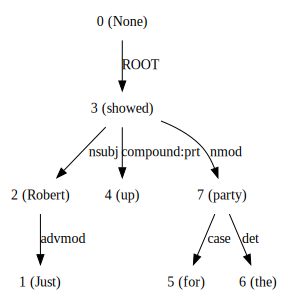

In [24]:
sent = 'Just Robert showed up for the party'
tree = next(parsers['syn'].raw_parse(sent))
tree.pretty_print()
next(parsers['dep'].raw_parse(sent))

In [ ]:
print(f"SEQ-L2R: {sort_text(sent, 'seq', parsers, 'left')}")
print(f"SYN-L2R: {sort_text(sent, 'syn', parsers, 'left')}")
print(f"DEP-L2R: {sort_text(sent, 'dep', parsers, 'left')}")
print(f"DEP-R2L: {sort_text(sent, 'dep', parsers, 'right')}")

In [27]:
---

## Word-Definition Dataset creation 2

---

SEQ-L2R: ['Just', 'Robert', 'showed', 'up', 'for', 'the', 'party']
SYN-L2R: [['Just', 'Robert'], ['showed', 'up', ['for', ['the', 'party']]]]
DEP-L2R: ['showed', ['Robert', 'Just'], 'up', ['party', 'for', 'the']]
DEP-R2L: [['Just', 'Robert'], 'up', ['for', 'the', 'party'], 'showed']


---

## Word-Definition Dataset creation 2

---

In [3]:
DATA_PATH = './data'
WV_FILE = 'GoogleNews-vectors-negative300.bin'
FILENAME = 'wordsim353.csv'

parsers = {'seq': CoreNLPParser(url='http://localhost:9000'),
           'syn': CoreNLPParser(url='http://localhost:9000'),
           'dep': CoreNLPDependencyParser(url='http://localhost:9000')}

In [5]:
word2vecs = KeyedVectors.load_word2vec_format(os.path.join(DATA_PATH, WV_FILE), binary=True)

In [7]:
wordsims = pd.read_csv(os.path.join(DATA_PATH, FILENAME), sep=',')
wordsim_words = set(wordsims["Word 1"].tolist() + wordsims["Word 2"].tolist())
wordsim_words = sorted(list([w for w in wordsim_words if w in word2vecs.vocab.keys() and wn.synsets(w)]))